In [161]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from camera_utils import fix_barrel_distortion
import math
import random
import os

In [162]:
def order_points(points):
    # Compute the sums and differences of the x and y coordinates
    sums = [p[0] + p[1] for p in points]
    diffs = [p[0] - p[1] for p in points]
    # Find the indices of the points with the smallest and largest sums
    topleft_index = np.argmin(sums)
    bottomright_index = np.argmax(sums)
    # Find the indices of the points with the smallest and largest differences
    topright_index = np.argmin(diffs)
    bottomleft_index = np.argmax(diffs)
    return np.float32([points[topleft_index], points[topright_index], points[bottomright_index], points[bottomleft_index]])

In [163]:
def random_image(folders):
    files = []
    for folder in folders:
        for dirpath, dirnames, filenames in os.walk(folder):
            for filename in filenames:
                files.append(os.path.join(dirpath, filename))
    if not files:
        return None
    else:
        return cv2.imread(random.choice(files))

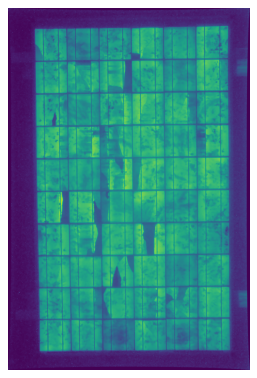

In [164]:
# image = cv2.imread("C:/Users/chuck/OneDrive/Desktop/Honors/EL_images/Q72712M1801AJO0421_IMG_8916.JPG", )
# image = cv2.imread("C:/Users/chuck/OneDrive/Desktop/Honors/BT1/BT1/F52J01525101_IMG_8993.JPG")
# image = cv2.imread("C:/Users/chuck/OneDrive/Desktop/Honors/EL_images/Q72712M1802ARK1119_IMG_8918.JPG")
# image = cv2.imread("C:/Users/chuck/OneDrive/Desktop/Honors/BT1/BT1/160101038544_IMG_8986.JPG")

folders = ["C:/Users/chuck/OneDrive/Desktop/Honors/M0060/M0060",
           "C:/Users/chuck/OneDrive/Desktop/Honors/BT1/BT1"]
image = random_image(folders)

toml_path = "C:/Users/chuck/OneDrive/Desktop/Honors/solarEL/solarel/configs/camera_config.toml"
image = fix_barrel_distortion(image, toml_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.fastNlMeansDenoising(image, None, 15, 7, 21)
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(image)

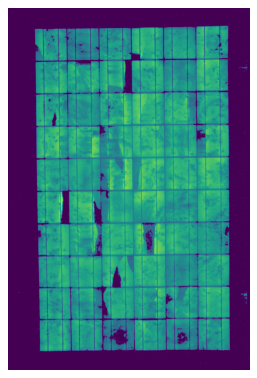

In [165]:
image_cp = np.copy(image)
image_cp = cv2.blur(image_cp, (5,5))
temp = np.ravel(image_cp)
avg_intensity = int(np.mean(temp))
_, thresh = cv2.threshold(image, avg_intensity - 0.3*np.std(temp), 255, cv2.THRESH_TOZERO)
# th3 = cv2.adaptiveThreshold(thresh,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#             cv2.THRESH_BINARY,11,2)
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(thresh)

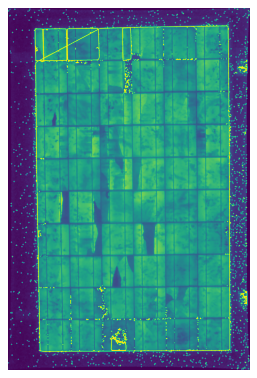

In [166]:
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
convexs = []
for cnt in contours:
    convexs.append(cv2.convexHull(cnt))

image_cp = cv2.drawContours(image_cp, convexs, -1, (255,255,255), 10)
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(image_cp)

In [167]:
def largest_rectangle(contours):
    # Approximate contours to polygons and find the largest rectangle
    largest_hull = None
    max_area = 0
    for cnt in contours:
        # Approximate the contour to a polygon
        poly = cv2.approxPolyDP(cnt, 0.05*cv2.arcLength(cnt,True), True)
        # If the polygon has 4 vertices (is a rectangle)
        if len(poly) == 4:
            # Calculate the area of the polygon
            area = cv2.contourArea(poly)
            # If the area is larger than the current maximum
            if area > max_area:
                # Update the maximum area and largest rectangle
                max_area = area
                largest_hull = cnt
    # Return the largest rectangle
    return largest_hull

rect = largest_rectangle(convexs)
# rect = np.reshape(rect, (4,2))
# rect = order_points(rect)



[[ 320.  240.]
 [ 354. 4060.]
 [2625. 4040.]
 [2590.  220.]]


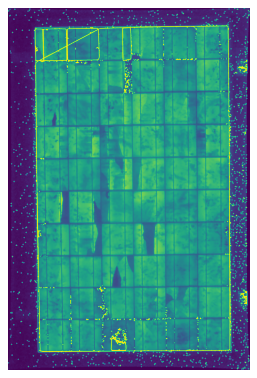

In [168]:
rect = cv2.minAreaRect(rect)
box = cv2.boxPoints(rect)
box = box.astype('int')
# Draw the polygon on the original image
cv2.drawContours(image_cp, [box], 0, (255, 255, 255), 3)
box = order_points(box)
print(box)

plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(image_cp)

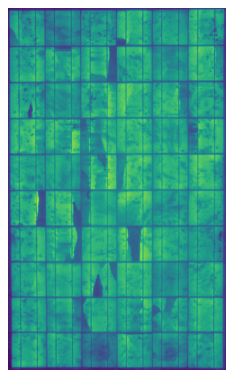

In [169]:

# Convert the list of points to a numpy array
rect = np.array(box)
x, y, w, h = cv2.boundingRect(rect)
height, width = np.shape(image_cp)[:2]
delta = 20
rect = np.array([[max(rect[0][0]-delta, 0), max(rect[0][1]-delta, 0)], \
                 [max(rect[1][0]-delta, 0), min(rect[1][1]+delta, height)],\
                    [min(rect[2][0]+delta, width), min(rect[2][1]+delta, height)], \
                    [min(rect[3][0]+delta, width), max(rect[3][1]-delta, 0)]])

# Reshape the array to a 1D array of (x, y) tuples
points = rect.reshape(-1, 2)
src_pts = np.float32(points)

dest_pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]])

M = cv2.getPerspectiveTransform(src_pts, dest_pts)
image_cp = np.copy(image)
# Apply the perspective transform to the image
cropped = cv2.warpPerspective(image_cp, M, (w, h))
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(cropped)

(3841, 2306)
(961, 577)


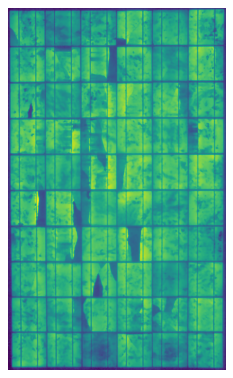

In [170]:
cropped_cp = np.copy(cropped)
print(np.shape(cropped_cp))
cropped_cp = cv2.pyrDown(cropped_cp)
cropped_cp = cv2.pyrDown(cropped_cp)
print(np.shape(cropped_cp))
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(cropped_cp)

In [171]:
# alpha = 1.3 # Simple contrast control
# beta = 20    # Simple brightness control

# out = np.copy(cropped_cp)
# for y in range(out.shape[0]):
#     for x in range(out.shape[1]):
#         out[y,x] = np.clip(alpha*out[y,x] + beta, 0, 255)

# cropped_cp = out
# plt.figure(figsize=(8, 6), dpi=80)
# plt.axis('off')
# plt.imshow(out)


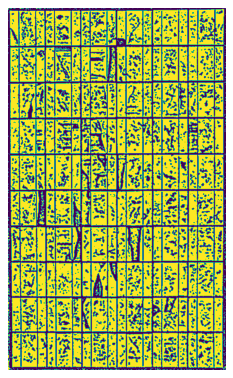

In [172]:
thresh1 = cv2.adaptiveThreshold(cropped_cp,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,17,2)
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(thresh1)

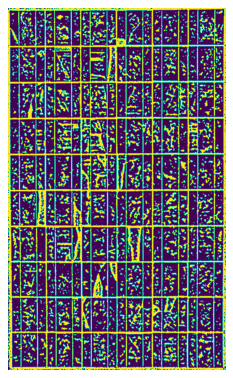

In [173]:
kernel = np.ones((1, 1), np.uint8)
thresh1 = cv2.dilate(thresh1, kernel) 
kernel = np.ones((2, 2), np.uint8)
hresh1 = cv2.erode(thresh1, kernel) 
thresh1 = cv2.bitwise_not(thresh1)
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(thresh1)

In [174]:
def horz_hough_lines(edges, votes, pixels):
    lines = None
    while lines is None:
        lines = cv2.HoughLines(edges, pixels, np.pi/180, votes)
        votes = int(votes*0.95)
        
    good_lines = []
    # Loop over the detected lines
    for line in lines:
        _, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        slope = - a / b if b != 0 else 100 # divide by zero saftey
        # Check if the line is approximately horizontal
        if abs(slope)<0.1:
            good_lines.append(line)
    return good_lines

def vert_hough_lines(edges, votes, pixels):
    lines = None
    while lines is None:
        lines = cv2.HoughLines(edges, pixels, np.pi/180, votes)
        votes = int(votes*0.95)

    good_lines = []
    # Loop over the detected lines
    for line in lines:
        _, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        slope = - a / b if b != 0 else 100 # divide by zero saftey
        # Check if the line is approximately horizontal
        if abs(slope)>50:
            good_lines.append(line)
    return good_lines

def draw_hough_lines(image, hough_lines):
    # Loop over the detected lines
    for line in hough_lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 +1200 * (-b))
        y1 = int(y0 + 1200 * (a))
        x2 = int(x0 - 1200 * (-b))
        y2 = int(y0 - 1200 * (a))
        cv2.line(image, (x1, y1), (x2, y2), (255, 255, 255), 2)
    return image

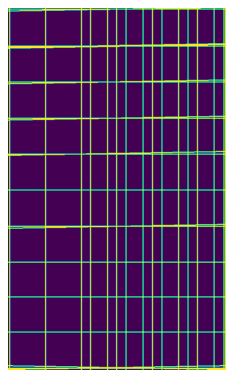

In [175]:
horz_lines = horz_hough_lines(thresh1, 400, 1)
vert_lines = vert_hough_lines(thresh1, 700, 1)
lines = horz_lines + vert_lines

thresh_cp = np.copy(thresh1) * 0
cells = draw_hough_lines(thresh_cp, lines)

plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(cells)

In [176]:
def merge_similar_hough_lines(lines, rho_threshold, theta_threshold):
    """
    Merges similar Hough lines in OpenCV.
    
    :param lines: list of lines in (rho, theta) format.
    :param threshold_distance: maximum distance between lines to be considered similar.
    :param threshold_angle: maximum angle difference between lines to be considered similar.
    :return: list of merged lines in (rho, theta) format.
    """

     # how many lines are similar to a given one
    similar_lines = {i : [] for i in range(len(lines))}
    for i in range(len(lines)):
        for j in range(len(lines)):
            if i == j:
                continue

            rho_i,theta_i = lines[i][0]
            rho_j,theta_j = lines[j][0]
            if abs(rho_i - rho_j) < rho_threshold and abs(theta_i - theta_j) < theta_threshold:
                similar_lines[i].append(j)

    # ordering the INDECES of the lines by how many are similar to them
    indices = [i for i in range(len(lines))]
    indices.sort(key=lambda x : len(similar_lines[x]))

    # line flags is the base for the filtering
    line_flags = len(lines)*[True]
    for i in range(len(lines) - 1):
        if not line_flags[indices[i]]: # if we already disregarded the ith element in the ordered list then we don't care (we will not delete anything based on it and we will never reconsider using this line again)
            continue

        for j in range(i + 1, len(lines)): # we are only considering those elements that had less similar line
            if not line_flags[indices[j]]: # and only if we have not disregarded them already
                continue

            rho_i,theta_i = lines[indices[i]][0]
            rho_j,theta_j = lines[indices[j]][0]
            if abs(rho_i - rho_j) < rho_threshold and abs(theta_i - theta_j) < theta_threshold:
                line_flags[indices[j]] = False # if it is similar and have not been disregarded yet then drop it now

    filtered_lines = []

    if filter:
        for i in range(len(lines)): # filtering
            if line_flags[i]:
                filtered_lines.append(lines[i])

    return filtered_lines

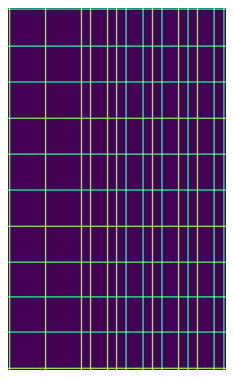

In [177]:
lines = merge_similar_hough_lines(lines, 20, 0.2)
lines = merge_similar_hough_lines(lines, 20, 0.2)
edges_cp = np.copy(thresh1) * 0
cells = draw_hough_lines(edges_cp, lines)

plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(cells)

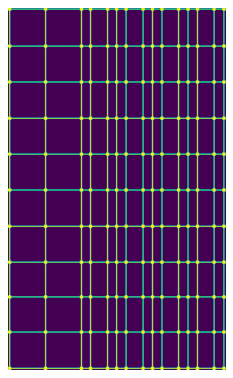

In [178]:
# Find intersections of lines
intersections = []
for i in range(len(lines)):
    for j in range(i+1, len(lines)):
        line1 = lines[i][0]
        line2 = lines[j][0]
        rho1, theta1 = line1
        rho2, theta2 = line2
        a1 = np.cos(theta1)
        b1 = np.sin(theta1)
        a2 = np.cos(theta2)
        b2 = np.sin(theta2)
        x0 = a1*rho1
        y0 = b1*rho1
        x1 = a2*rho2
        y1 = b2*rho2
        d = a1*b2 - a2*b1
        if d != 0:
            x = int((b2*x0 - b1*x1) / d)
            y = int((a1*y1 - a2*y0) / d)
            intersections.append((x,y))

# Draw intersections on the image
for point in intersections:
    cv2.circle(cells, point, 5, (255,255,255), -1)

plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(cells)

In [179]:
def get_outside_vert_points(points, delta_width):
    outside_points = []
    
    sorted_points = sorted(points, key=lambda pt: pt[0])

    min_x = sorted_points[0][0]
    max_x = sorted_points[-1][0]

    left_boundary = min_x
    right_boundary = left_boundary + delta_width

    for pt in points:
        if pt[0] >= left_boundary and pt[0] <= right_boundary:
            outside_points.append(pt)
    
    left_boundary = max_x - delta_width
    right_boundary = max_x

    for pt in points:
        if pt[0] >= left_boundary and pt[0] <= right_boundary:
            outside_points.append(pt)

    return outside_points

def get_outside_horz_points(points, delta_width):
    outside_points = []
    sorted_points = sorted(points, key=lambda pt: pt[1])

    min_y = sorted_points[0][1]
    max_y = sorted_points[-1][1]

    upper_boundary = min_y
    bottom_boundary = min_y + delta_width

    for pt in points:
        if pt[1] <= bottom_boundary and pt[1] >= upper_boundary:
            outside_points.append(pt)
    
    upper_boundary = max_y - delta_width
    bottom_boundary = max_y

    for pt in points:
        if pt[1] <= bottom_boundary and pt[1] >= upper_boundary:
            outside_points.append(pt)
            
    return outside_points

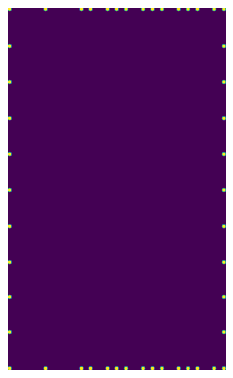

In [180]:
vert_points = get_outside_vert_points(intersections, 5)
horz_points = get_outside_horz_points(intersections, 5)

outside = vert_points + horz_points
cells_cp = np.copy(cells)*0
for point in outside:
    cv2.circle(cells_cp, point, 5, (255,255,255), -1)

plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(cells_cp)

In [181]:
print(len(vert_points))
print(vert_points[-2])

22
(571, 956)


In [182]:
def merge_points(points, radius):
    merged_points = []
    processed_points = set()

    for i, point1 in enumerate(points):
        if i in processed_points:
            continue

        merged_point = point1
        count = 1

        for j, point2 in enumerate(points[i+1:]):
            j += i+1

            if j in processed_points:
                continue

            dist = math.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

            if dist <= radius:
                merged_point = (int((merged_point[0]*count + point2[0])/(count+1)), 
                                int((merged_point[1]*count + point2[1])/(count+1)))
                count += 1
                processed_points.add(j)

        merged_points.append(merged_point)

    return merged_points

In [183]:
merged_vert = merge_points(vert_points, 5)
merged_horz = merge_points(horz_points, 5)

print(len(merged_vert))
print(len(merged_horz))

22
30


In [184]:
LHS_vert = sorted(merged_vert, key=lambda pt: pt[0])[:len(merged_vert)//2]
LHS_vert = sorted(LHS_vert, key=lambda pt: pt[1])
RHS_vert = sorted(merged_vert, key=lambda pt: pt[0])[len(merged_vert)//2:]
RHS_vert = sorted(RHS_vert, key=lambda pt: pt[1])

UPPER_horz = sorted(merged_horz, key=lambda pt: pt[1])[:len(merged_horz)//2]
UPPER_horz = sorted(UPPER_horz, key=lambda pt: pt[0])
LOWER_horz = sorted(merged_horz, key=lambda pt: pt[1])[len(merged_horz)//2:]
LOWER_horz = sorted(LOWER_horz, key=lambda pt: pt[0])

print(LHS_vert, len(LHS_vert))
print(RHS_vert, len(RHS_vert))
print(UPPER_horz, len(UPPER_horz))
print(LOWER_horz, len(LOWER_horz))

[(4, 5), (4, 103), (4, 198), (4, 294), (4, 389), (4, 484), (4, 580), (4, 675), (4, 767), (4, 860), (4, 956)] 11
[(571, 5), (571, 103), (571, 198), (571, 294), (571, 389), (571, 484), (571, 580), (571, 675), (571, 767), (571, 860), (571, 956)] 11
[(4, 5), (99, 5), (194, 5), (218, 5), (263, 5), (287, 5), (312, 5), (357, 5), (382, 5), (407, 5), (451, 5), (476, 5), (501, 5), (545, 5), (571, 5)] 15
[(4, 956), (99, 956), (194, 956), (218, 956), (263, 956), (287, 956), (312, 956), (357, 956), (382, 956), (407, 956), (451, 956), (476, 956), (501, 956), (545, 956), (571, 956)] 15


In [185]:
distances_vert = []
for i in range(len(LHS_vert)-1):
    distances_vert.append(LHS_vert[i+1][1]-LHS_vert[i][1])
for i in range(len(RHS_vert)-1):
    distances_vert.append(RHS_vert[i+1][1]-RHS_vert[i][1])

distances_horz = []
for i in range(len(UPPER_horz)-1):
    distances_horz.append(UPPER_horz[i+1][0]-UPPER_horz[i][0])
for i in range(len(LOWER_horz)-1):
    distances_horz.append(LOWER_horz[i+1][0]-LOWER_horz[i][0])


print(distances_vert)
print(distances_horz)

[98, 95, 96, 95, 95, 96, 95, 92, 93, 96, 98, 95, 96, 95, 95, 96, 95, 92, 93, 96]
[95, 95, 24, 45, 24, 25, 45, 25, 25, 44, 25, 25, 44, 26, 95, 95, 24, 45, 24, 25, 45, 25, 25, 44, 25, 25, 44, 26]


In [186]:
def sum_previous_elements(lst):
    result = []
    running_sum = 0
    for i in lst:
        running_sum += i
        result.append(running_sum)
    return result

def closest_number_index(lst, target):
    closest_index = 0
    for i in range(1, len(lst)):
        if abs(lst[i] - target) < abs(lst[closest_index] - target):
            closest_index = i
    return closest_index

if(np.mean(distances_vert) > np.mean(distances_horz)):
    # bus bars possibly horz
    # assume square cell
    width = np.mean(distances_vert)
    horz_sums = sum_previous_elements(distances_horz)
    segments = closest_number_index(horz_sums, width) + 1
    # take every segments point horizontally
    UPPER_horz = UPPER_horz[0::segments]
    UPPER_horz = LOWER_horz[0::segments]
else:
    # bus bars possibly vert
    # assume square cell
    height = np.mean(distances_horz)
    vert_sums = sum_previous_elements(distances_vert)
    segments = closest_number_index(vert_sums, height) + 1
    # take every segments point horizontally
    LHS_vert = LHS_vert[0::segments]
    RHS_vert = RHS_vert[0::segments]


print(np.std(distances_horz))
print(np.std(distances_vert))

23.846982438635113
1.5779733838059498


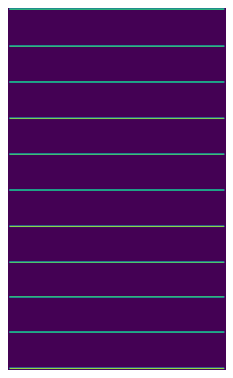

In [187]:
cells_cp = np.copy(cells)*0
for i, point in enumerate(LHS_vert):
    cv2.line(cells_cp, point, RHS_vert[i], (255, 255, 255), 2)

for i, point in enumerate(LOWER_horz):
    cv2.line(cells_cp, point, UPPER_horz[i], (255, 255, 255), 2)

plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(cells_cp)

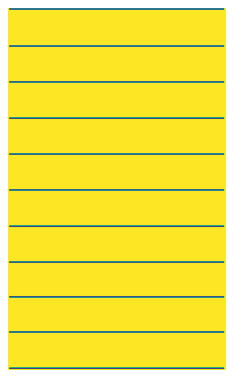

In [188]:
cells = cv2.pyrUp(cells_cp)
cells = cv2.pyrUp(cells)
_, cells = cv2.threshold(cells, 100, 255, cv2.THRESH_BINARY)
cells = cv2.dilate(cells, (2,2))
cells = cv2.erode(cells, (2,2))
cells = cv2.bitwise_not(cells)

plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(cells)

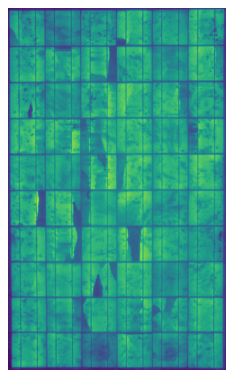

In [189]:
def find_similar_contours(example_shape, contours):
    similar_contours = []
    for contour in contours:
        # Approximate the contour with a polygon
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
        similarity = cv2.matchShapes(approx, example_shape, cv2.CONTOURS_MATCH_I1, 0)
        if similarity < 0.05:
            similar_contours.append(contour)
    return similar_contours

contours, hierarchy = cv2.findContours(cells, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
panel_shape = np.array([[0,0], [0,1], [1,1], [1,0]])
panel_contours = find_similar_contours(panel_shape, contours)
cropped_cp = np.copy(cropped)
cropped = cv2.drawContours(cropped, panel_contours, -1, (255,255,255), 10)
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(cropped)

In [190]:
panel_images = []

def width_and_height_filter(contours, width, height, tolerance):
    good_contours = []
    for contour in panel_contours:
        _, _, w, h = cv2.boundingRect(contour)
        if w < width*(1-tolerance) or w > width * (1+tolerance):
            continue
        if h < height*(1-tolerance) or w > height * (1+tolerance):
            continue
        good_contours.append(contour)
    return good_contours

panel_contours = width_and_height_filter(panel_contours, 325, 325, 0.2)

In [191]:
def sort_contours(contours):
    centers = []
    for contour in contours:
        M = cv2.moments(contour)
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        centers.append((cx, cy))
    
    # Sort the contours by their x-coordinate
    sorted_indices = np.argsort([center[1] for center in centers])
    sorted_contours = [contours[i] for i in sorted_indices]

     # Split the contours into rows
    rows = []
    row_indices = []
    prev_center_y = None
    for i, contour in enumerate(sorted_contours):
        center_x, center_y = centers[sorted_indices[i]]
        if prev_center_y is None or center_y - prev_center_y > 10:
            row_indices.append([i])
            rows.append([contour])
        else:
            row_indices[-1].append(i)
            rows[-1].append(contour)
        prev_center_y = center_y
    
    # Sort the contours within each row by their x-coordinate
    for i, row in enumerate(rows):
        row_sorted_indices = np.argsort([centers[sorted_indices[j]][0] for j in row_indices[i]])
        rows[i] = [row[j] for j in row_sorted_indices]

    return rows

rows = sort_contours(panel_contours)

In [192]:
def label_image(image, text,font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=2, color=(255, 255, 255), thickness=2):
    # Get the dimensions of the image
    height, width = image.shape
    
    # Get the dimensions of the text
    text_width, text_height = cv2.getTextSize(text, font, font_scale, thickness)[0]
    
    # Compute the position of the text
    text_x = int((width - text_width) / 2)
    text_y = int((height + text_height) / 2)
    
    # Put the text on the image
    cv2.putText(image, text, (text_x, text_y), font, font_scale, (0,0,0), thickness+1)
    cv2.putText(image, text, (text_x, text_y), font, font_scale, color, thickness)

In [193]:
i = 0
height, width = np.shape(cropped_cp)
panel_image_rows = []
for row in rows:
    panel_image_rows.append([])
    for contour in row:
        x,y,w,h = cv2.boundingRect(contour)
        print(x,y,w,h)
        delta = 0
        panel_image = cropped_cp[max(0, y-delta):min(y+h+delta, height), max(0, x-delta):min(x+w+delta, width)]
        label_image(panel_image, f'{i}')
        panel_images.append(panel_image)
        panel_image_rows[-1].append(panel_image)
        i += 1


example = random.choice(panel_images)
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(example)

IndexError: list index out of range

c:\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


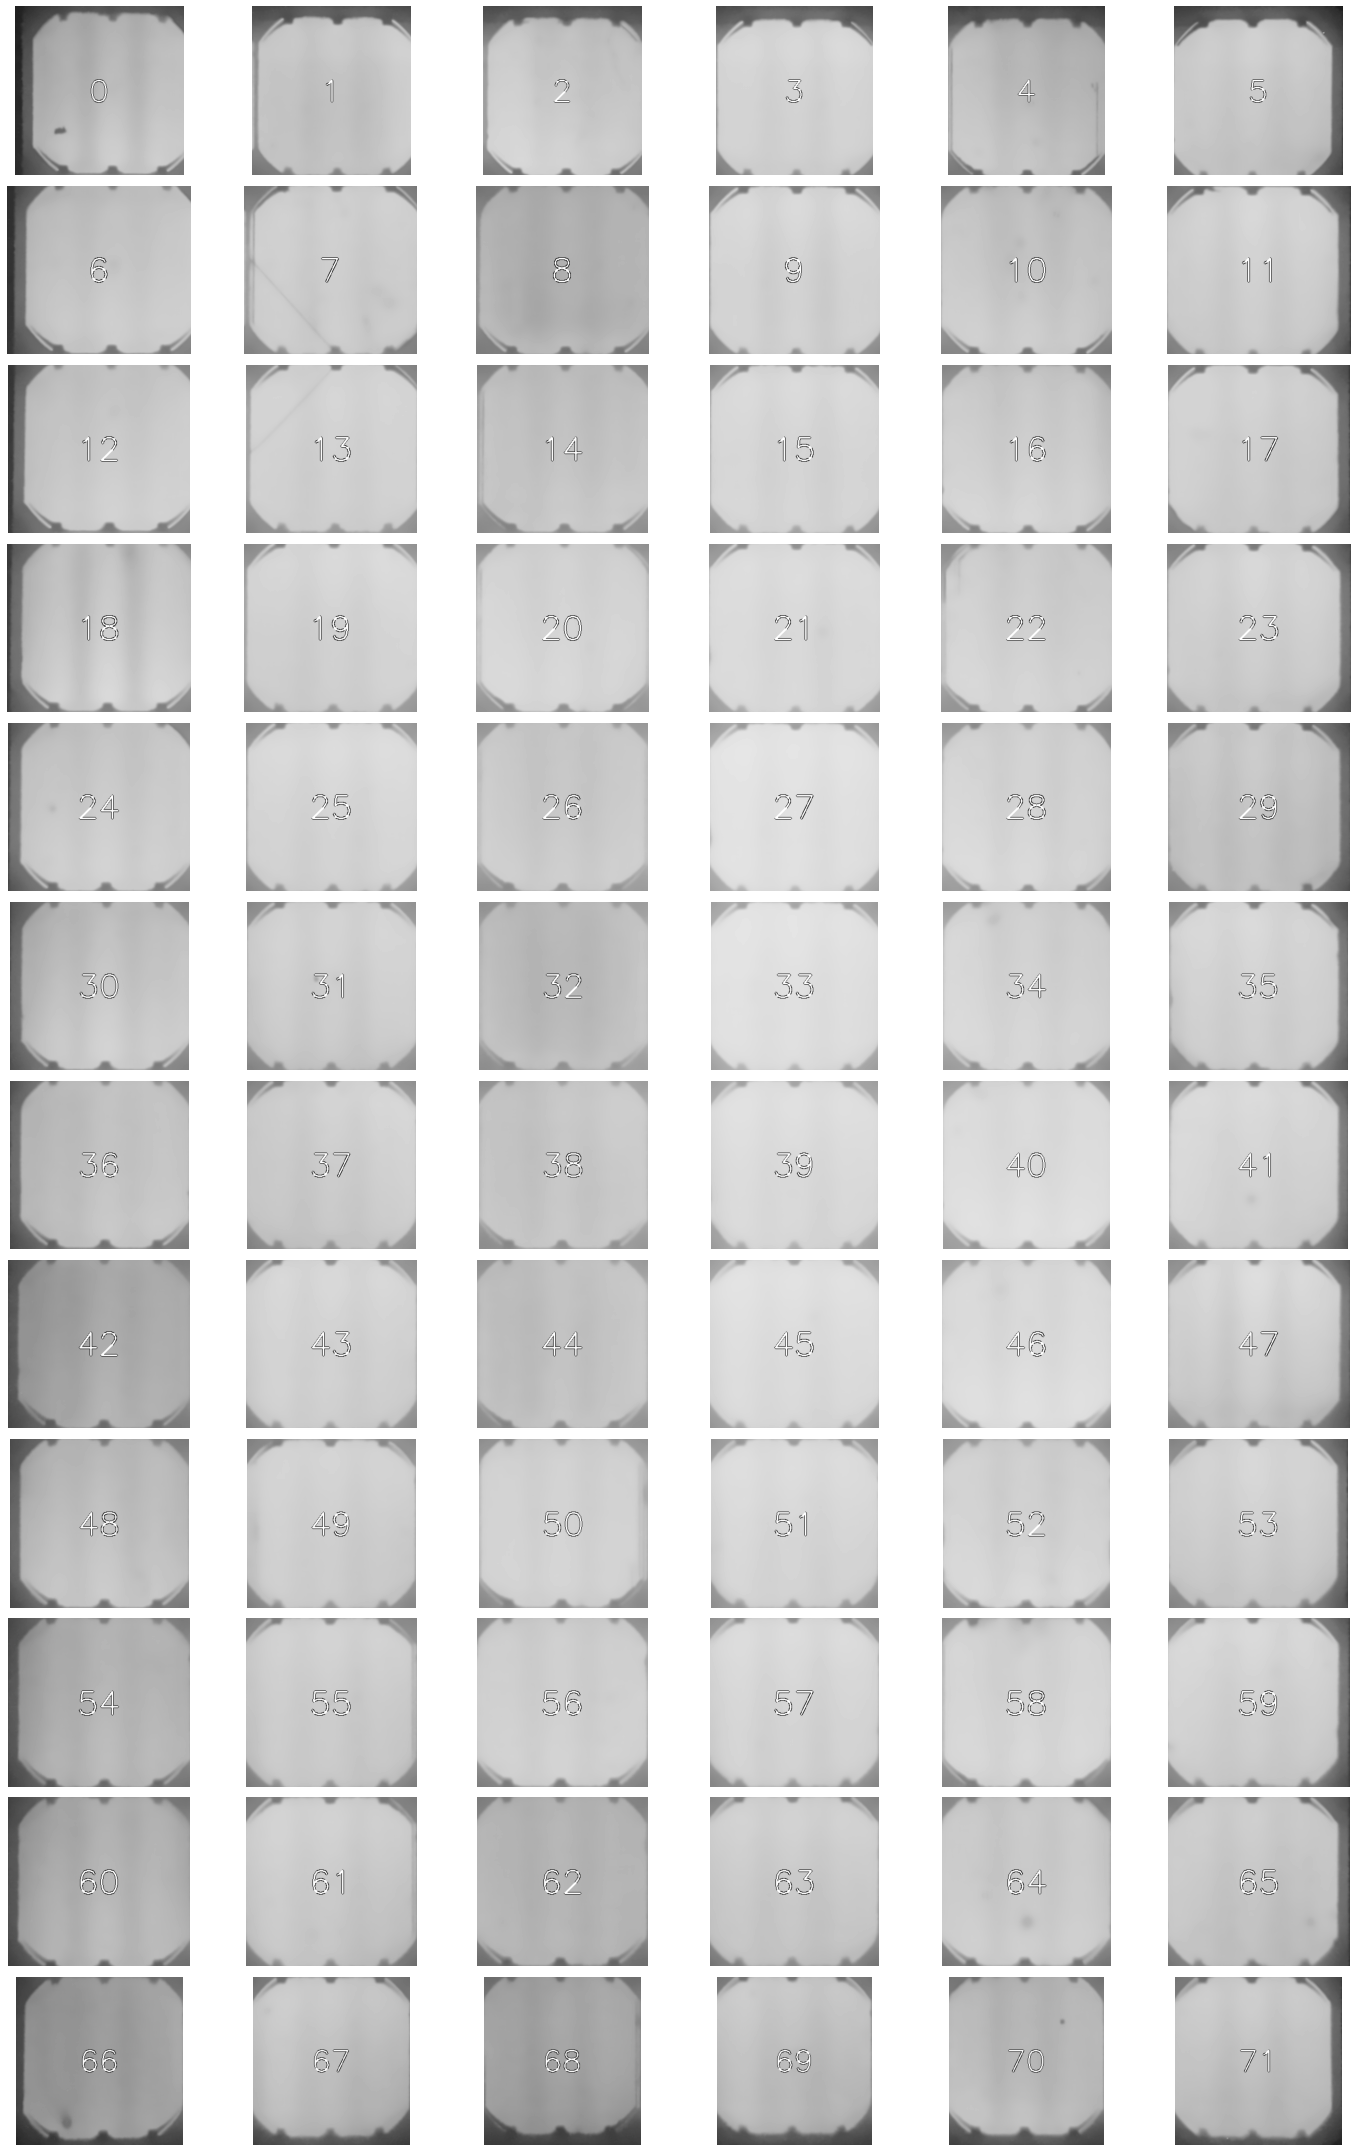

In [ ]:

num_rows, num_cols = np.shape(panel_image_rows)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 30))

for row in range(num_rows):
    for col in range(num_cols):
        # Generate a random image for each subplot
        image = panel_image_rows[row][col]

        # Display the image in the current subplot
        axs[row, col].imshow(image, cmap='gray')
        axs[row, col].axis('off')

# Adjust the spacing between subplots
fig.tight_layout()
# Show the plot
plt.show()

# Cell Clean up

(339, 319)


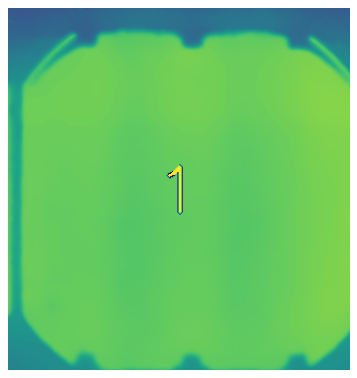

In [ ]:
example = panel_images[1]
print(np.shape(example))
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(example)

In [ ]:
example_1 = np.copy(example)

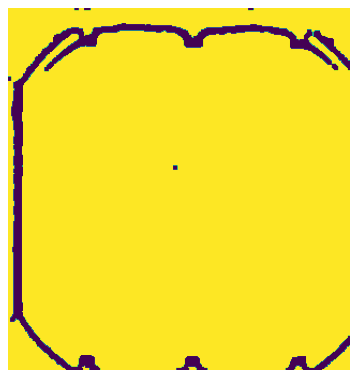

In [ ]:
th3 = cv2.adaptiveThreshold(example,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,17,2)
kernel = np.ones((4, 4), np.uint8)
th3 = cv2.dilate(th3, kernel)
kernel = np.ones((4, 4), np.uint8)
th3 = cv2.erode(th3, kernel) 
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(th3)
th3 = cv2.bitwise_not(th3)

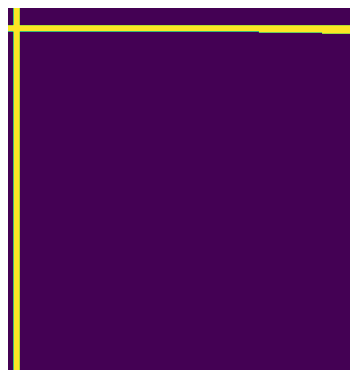

In [ ]:
# horz_lines = horz_hough_lines(th3, 350, 1.5)
# vert_lines = vert_hough_lines(th3, 350, 1.5)

horz_lines = horz_hough_lines(th3, 280, 1.5)
vert_lines = vert_hough_lines(th3, 350, 1.5)

lines = horz_lines + vert_lines

th3_cp = np.copy(th3) * 0
th3_cp = draw_hough_lines(th3_cp, lines)

plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(th3_cp)

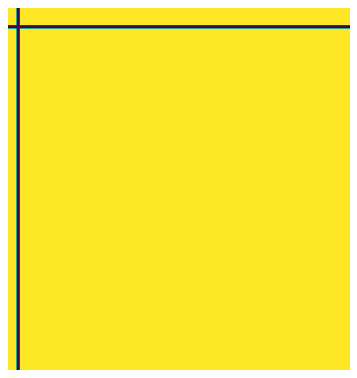

In [ ]:
lines = merge_similar_hough_lines(lines, 15, 0.2)
th3_cp = np.copy(th3_cp) * 0
cell = draw_hough_lines(th3_cp, lines)
cell = cv2.bitwise_not(cell)
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(cell)

In [ ]:
def find_largest_contour(thresholded_img):
    contours, hierarchy = cv2.findContours(thresholded_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
    return approx

cell_poly = find_largest_contour(cell)
cell_poly = cell_poly.reshape(4,2)
print(cell_poly)

[[ 11  20]
 [ 11 338]
 [318 338]
 [318  20]]


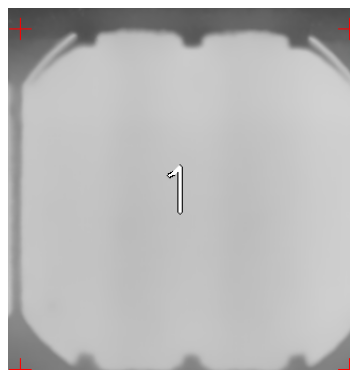

In [ ]:
example_cp = np.copy(example)
example_cp = cv2.cvtColor(example_cp, cv2.COLOR_GRAY2BGR) 
for point in cell_poly:
    cv2.drawMarker(example_cp, point, (255,0,0))

plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(example_cp)

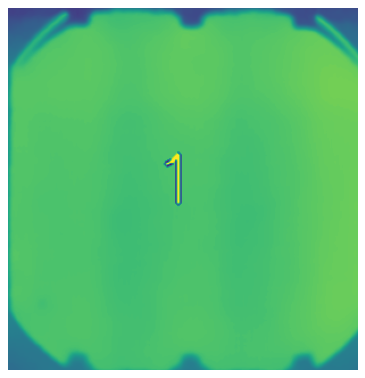

In [ ]:

def reproject(image, original_pts, destination_pts):
    # Get perspective transform M
    original_pts = order_points(original_pts)
    destination_pts = order_points(destination_pts)
    # print(original_pts)
    # print(destination_pts)
    M = cv2.getPerspectiveTransform(original_pts, destination_pts)
    size = int(dest_pts[3][0]), int(dest_pts[3][1])
    return cv2.warpPerspective(image, M, size)


x, y, w, h = cv2.boundingRect(cell_poly)
dest_pts = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
reprojected_cell = reproject(example, cell_poly, dest_pts)
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(reprojected_cell)

In [ ]:
print(np.shape(example))
print(cell_poly)
print(x, y, w, h)

(339, 319)
[[ 11  20]
 [ 11 338]
 [318 338]
 [318  20]]
11 20 308 319


In [ ]:
def clean_cell(raw_cell):
    raw_cell_cp = np.copy(raw_cell)

    thresh = cv2.adaptiveThreshold(raw_cell_cp,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,17,2)
    kernel = np.ones((4, 4), np.uint8)
    thresh = cv2.dilate(thresh, kernel)
    kernel = np.ones((4, 4), np.uint8)
    thresh = cv2.erode(thresh, kernel) 
    thresh = cv2.bitwise_not(thresh)

    horz_lines = horz_hough_lines(thresh, 280, 1.5)
    vert_lines = vert_hough_lines(thresh, 350, 1.5)

#     horz_lines = horz_hough_lines(thresh, 350, 1.5)
#     vert_lines = vert_hough_lines(thresh, 350, 1.5)

    lines = horz_lines + vert_lines
    lines = merge_similar_hough_lines(lines, 15, 0.2)
    thresh_cp = np.copy(thresh) * 0
    cell = draw_hough_lines(thresh_cp, lines)
    cell = cv2.bitwise_not(cell)

    cell_poly = find_largest_contour(cell)
    cell_poly = cell_poly.reshape(4,2)

    x, y, w, h = cv2.boundingRect(cell_poly)
    dest_pts = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
    return reproject(raw_cell, cell_poly, dest_pts)

0 0
0 1
0 2
0 3
0 4
0 5
1 0
1 1
1 2
1 3
1 4
1 5
2 0
2 1
2 2
2 3
2 4
2 5
3 0
3 1
3 2
3 3
3 4
3 5
4 0
4 1
4 2
4 3
4 4
4 5
5 0
5 1
5 2
5 3
5 4
5 5
6 0
6 1
6 2
6 3
6 4
6 5
7 0
7 1
7 2
7 3
7 4
7 5
8 0
8 1
8 2
8 3
8 4
8 5
9 0
9 1
9 2
9 3
9 4
9 5
10 0
10 1
10 2
10 3
10 4
10 5
11 0
11 1
11 2
11 3
11 4
11 5


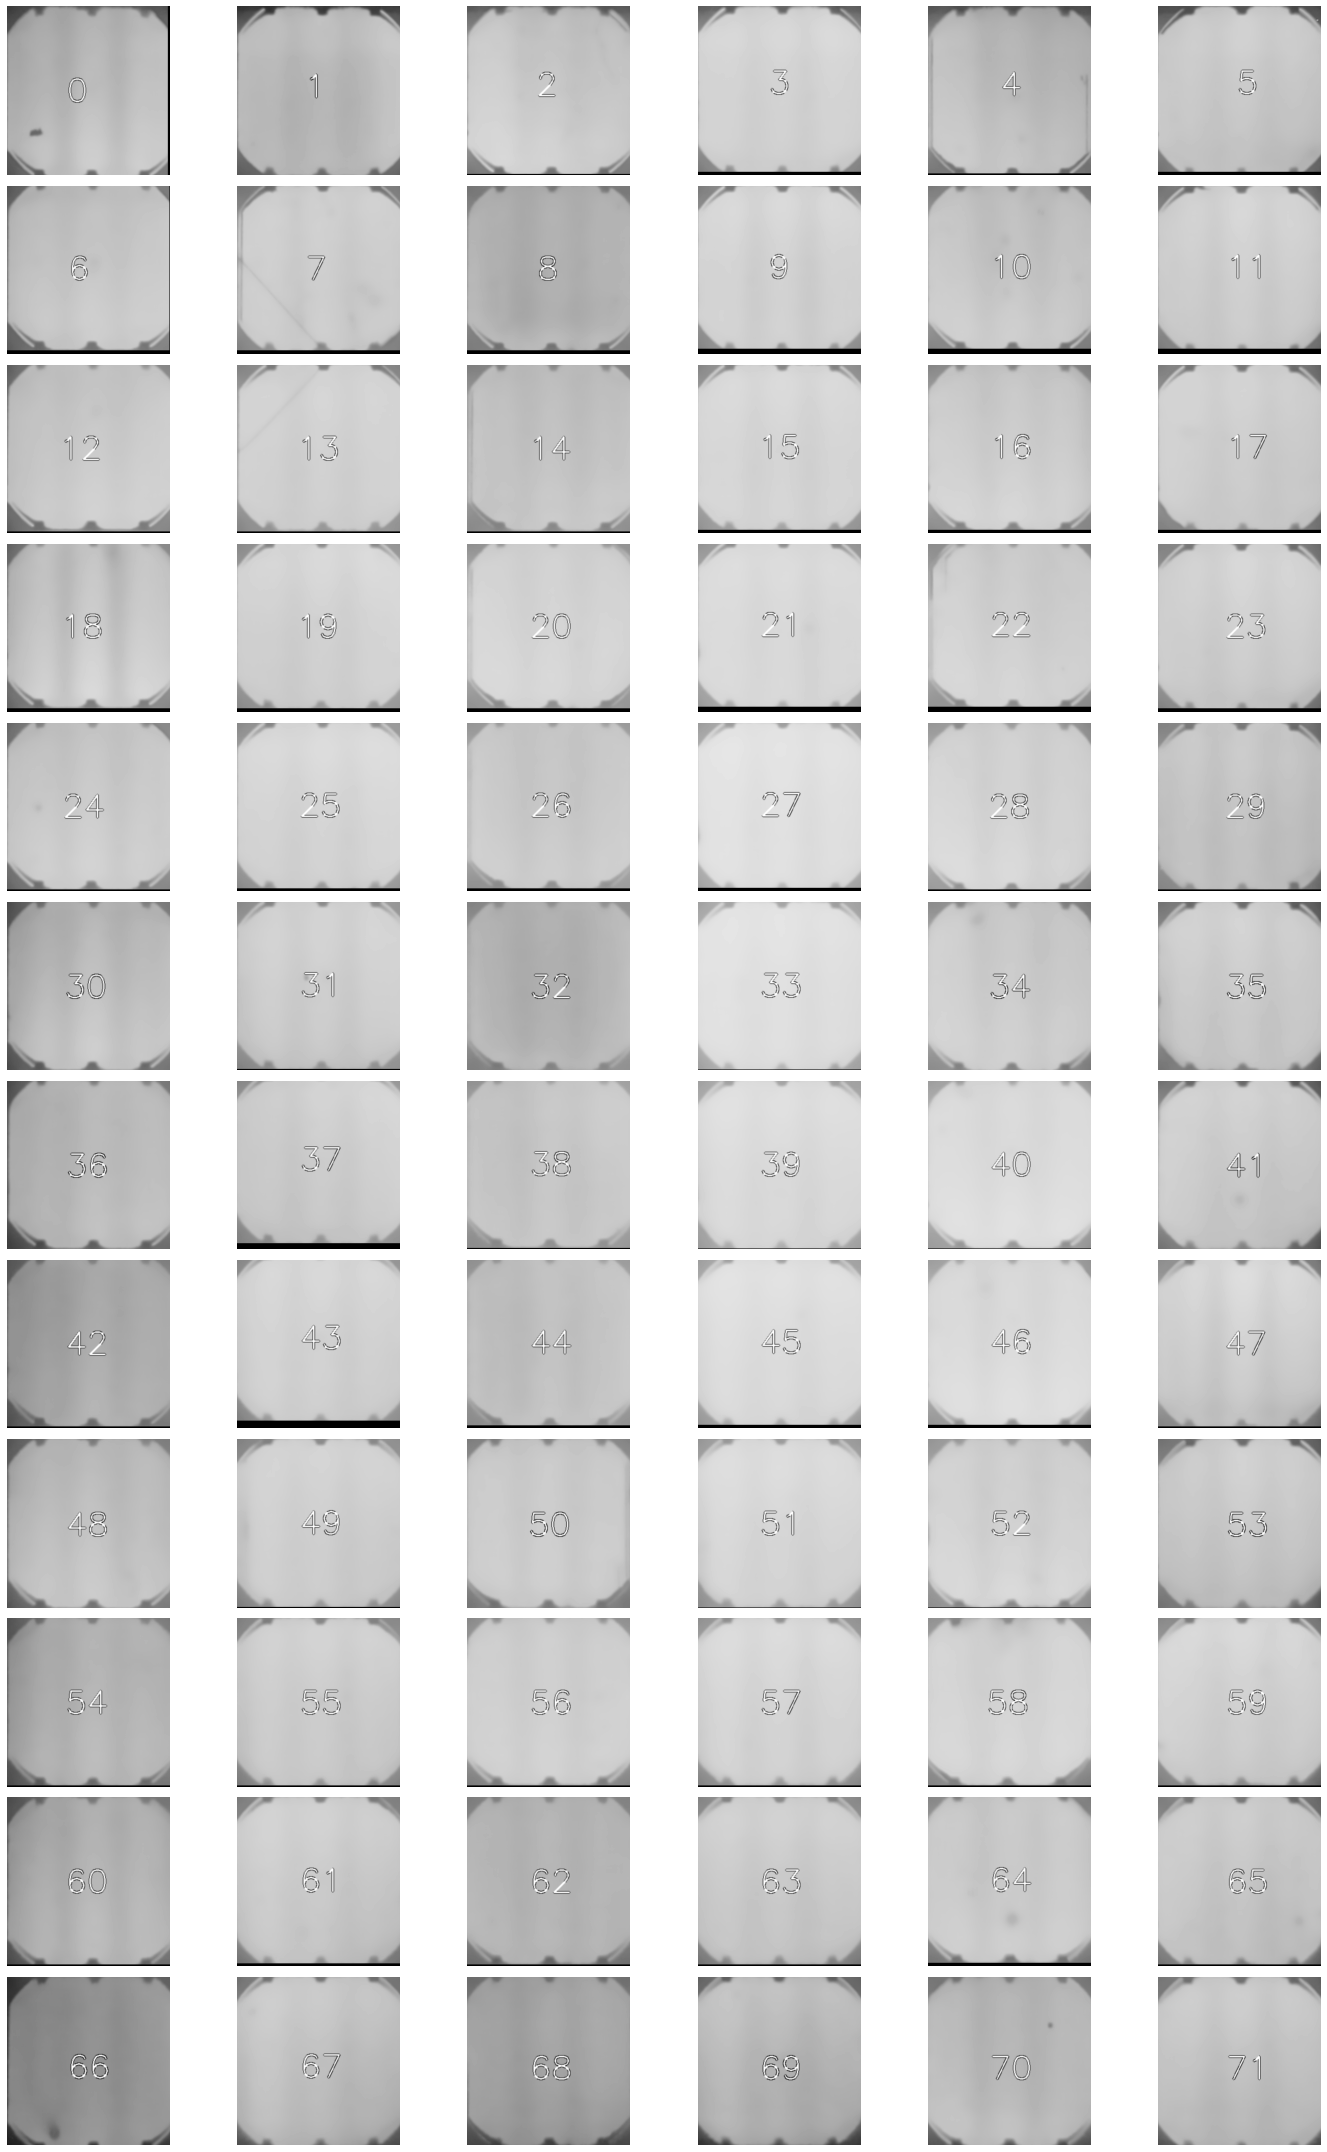

In [ ]:
num_rows, num_cols = np.shape(panel_image_rows)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 30))

for row in range(num_rows):
    for col in range(num_cols):
        # Generate a random image for each subplot
        print(row, col)
        image = panel_image_rows[row][col]
        image = clean_cell(image)

        # Display the image in the current subplot
        axs[row, col].imshow(image, cmap='gray')
        axs[row, col].axis('off')

# Adjust the spacing between subplots
fig.tight_layout()
# Show the plot
plt.show()